In [9]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import nest_asyncio
nest_asyncio.apply()
import datetime as dt
import re
import string
import csv
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
# from keras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [10]:
df = pd.read_csv("vaksinasi_covid_surabaya.csv", delimiter=",")


df.head()

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Sat May 30 23:57:00 +0000 2020,1266881326000435201,"Selamat ulang tahun Surabaya, segera pulih, ma...",0,0,0,0,in,369917928,1266881326000435201,catatanjeda,https://twitter.com/catatanjeda/status/1266881...
1,Sat May 30 23:55:56 +0000 2020,1266881058064101376,Selamat Hari Jadi Kota Surabaya ke-727. Semog...,0,0,0,2,in,3370537392,1266881058064101376,pppjatim_dpw,https://twitter.com/pppjatim_dpw/status/126688...
2,Sat May 30 23:49:38 +0000 2020,1266879473384734720,@kompasiana @kompascom Memang dilema yg masuk ...,0,0,0,0,in,1115451142547181569,1266540093008838658,Hamirun1,https://twitter.com/Hamirun1/status/1266879473...
3,Sat May 30 23:49:32 +0000 2020,1266879448801894400,"Maia Estianty Berduka, Tantenya Meninggal Duni...",1,0,2,1,in,58880688,1266879448801894400,pikiran_rakyat,https://twitter.com/pikiran_rakyat/status/1266...
4,Sat May 30 23:45:37 +0000 2020,1266878462867804160,"Ada yg beda di Ulang Tahun Kota Surabaya, bias...",0,0,0,6,in,1144602895934881792,1266878462867804160,sarishintaa,https://twitter.com/sarishintaa/status/1266878...


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   created_at           1400 non-null   object
 1   id_str               1400 non-null   int64 
 2   full_text            1400 non-null   object
 3   quote_count          1400 non-null   int64 
 4   reply_count          1400 non-null   int64 
 5   retweet_count        1400 non-null   int64 
 6   favorite_count       1400 non-null   int64 
 7   lang                 1400 non-null   object
 8   user_id_str          1400 non-null   int64 
 9   conversation_id_str  1400 non-null   int64 
 10  username             1400 non-null   object
 11  tweet_url            1400 non-null   object
dtypes: int64(7), object(5)
memory usage: 131.4+ KB


In [12]:
unique_lang_values = df['lang'].unique()
unique_lang_values

array(['in', 'en', 'zh', 'tl', 'qme', 'pl', 'fi'], dtype=object)

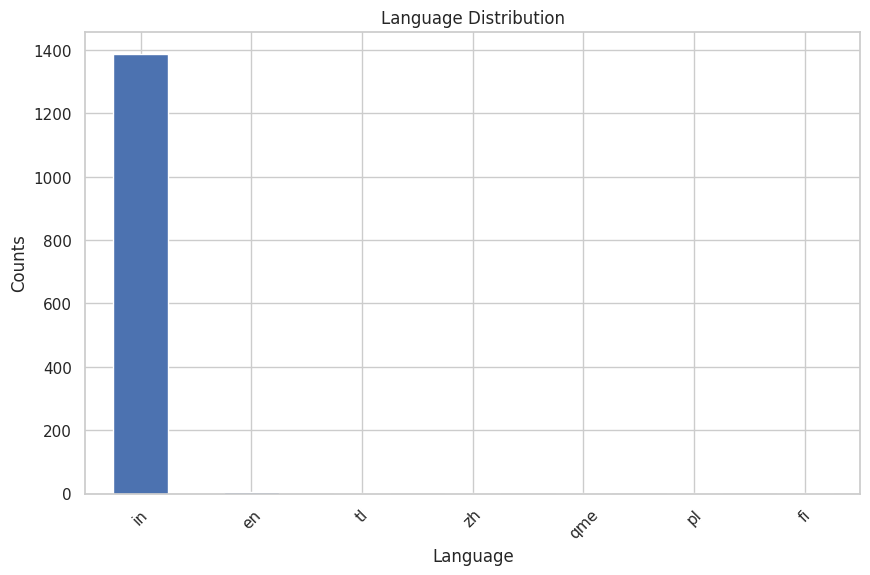

In [13]:
# Count the occurrences of each language
lang_counts = df['lang'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
lang_counts.plot(kind='bar')
plt.title('Language Distribution')
plt.xlabel('Language')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

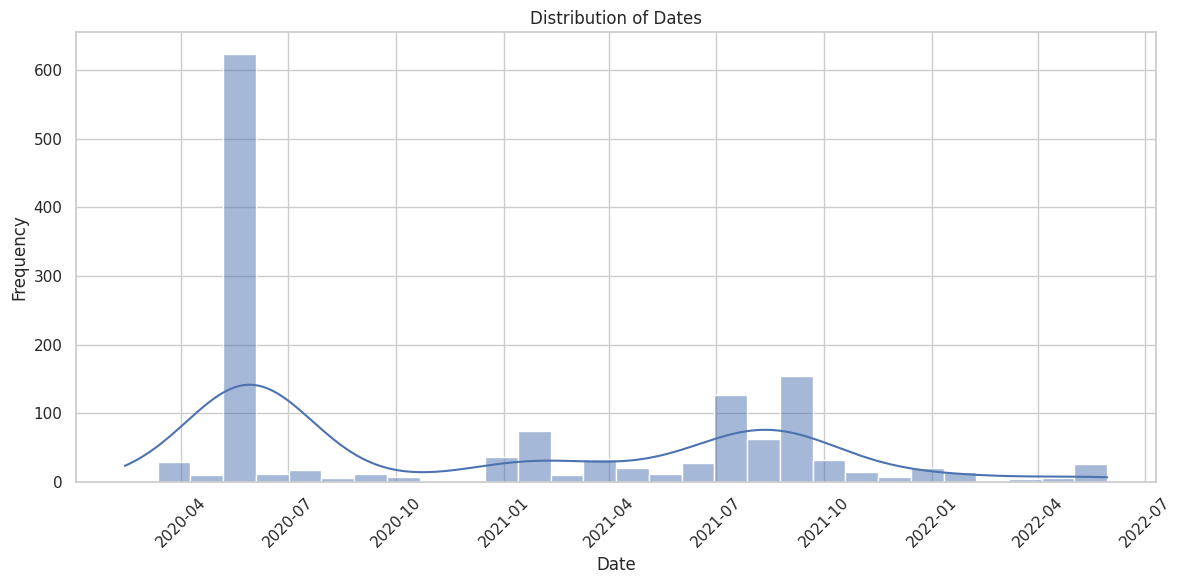

In [14]:
# Parsing the dates from the 'date' column
df['parsed_date'] = pd.to_datetime(df['created_at'])

# Extracting year, month, and day for better analysis
df['year'] = df['parsed_date'].dt.year
df['month'] = df['parsed_date'].dt.month
df['day'] = df['parsed_date'].dt.day

# Plotting the distribution of dates
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='parsed_date', bins=30, kde=True)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Distribution of Dates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
df = df.drop([
    "id_str",
    "quote_count",
    "reply_count",
    "retweet_count",
    "favorite_count",
    "user_id_str",
    "conversation_id_str",
    "username",
    "created_at",
    "lang",
    "tweet_url",

    "year",
    "month",
    "day",
    "parsed_date",
], axis=1)
df.head()

,full_text
0,"Selamat ulang tahun Surabaya, segera pulih, ma..."
1,Selamat Hari Jadi Kota Surabaya ke-727. Semog...
2,@kompasiana @kompascom Memang dilema yg masuk ...
3,"Maia Estianty Berduka, Tantenya Meninggal Duni..."
4,"Ada yg beda di Ulang Tahun Kota Surabaya, bias..."


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  1400 non-null   object
dtypes: object(1)
memory usage: 11.1+ KB


In [17]:
df.head(5)

,full_text
0,"Selamat ulang tahun Surabaya, segera pulih, ma..."
1,Selamat Hari Jadi Kota Surabaya ke-727. Semog...
2,@kompasiana @kompascom Memang dilema yg masuk ...
3,"Maia Estianty Berduka, Tantenya Meninggal Duni..."
4,"Ada yg beda di Ulang Tahun Kota Surabaya, bias..."


In [18]:
df.rename(columns={"full_text": "tweets"}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  1400 non-null   object
dtypes: object(1)
memory usage: 11.1+ KB


In [19]:
import nltk
nltk.download('punkt')

# Membuat stemmer dan stopword remover menggunakan Sastrawi
stemmer = StemmerFactory().create_stemmer()
stopword_factory = StopWordRemoverFactory()
stopwords = set(stopword_factory.get_stop_words())

# Fungsi untuk pembersihan teks
def clean_text(text):
    text = text.lower()  # Mengubah teks menjadi huruf kecil
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    text = emoji_pattern.sub(r'', text)  # Menghapus emoji
    text = re.sub(r'\d+', '', text)  # Menghapus angka
    text = re.sub(r'https?:\/\/\S+', '', text)  # Menghapus URL
    text = re.sub(r'RT[\s]', '', text) # Menghapus Retweet
    text = re.sub(r"@\S+", "", text)  # Menghapus mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # Menghapus hashtags
    text = re.sub(r'[^a-z\s]', '', text)  # Menghapus karakter selain huruf dan spasi
    return text

# Fungsi untuk preprocessing teks
def preprocess_text(text):
    cleaned = clean_text(text)
    tokens = word_tokenize(cleaned)
    tokens = [token for token in tokens if token not in stopwords]
    stemmed = stemmer.stem(' '.join(tokens))
    return stemmed

# Fungsi untuk tokenisasi tweet
def tokenize_tweet(text):
    return text.split()

# Menghapus tweet yang sama
df = df.drop_duplicates(subset='tweets')

# Preprocessing semua tweets
df['preprocessed_tweets'] = df['tweets'].apply(preprocess_text)

# Menerapkan tokenisasi ke setiap tweet
df['tokenized_tweets'] = df['preprocessed_tweets'].apply(tokenize_tweet)

# Menampilkan beberapa data setelah preprocessing dan tokenized
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,tweets,preprocessed_tweets,tokenized_tweets
0,"Selamat ulang tahun Surabaya, segera pulih, ma...",selamat ulang tahun surabaya pulih masyarakat ...,"[selamat, ulang, tahun, surabaya, pulih, masya..."
1,Selamat Hari Jadi Kota Surabaya ke-727. Semog...,selamat kota surabaya moga bebas pandemi covid,"[selamat, kota, surabaya, moga, bebas, pandemi..."
2,@kompasiana @kompascom Memang dilema yg masuk ...,dilema yg surabaya bawa virus surabaya positif...,"[dilema, yg, surabaya, bawa, virus, surabaya, ..."
3,"Maia Estianty Berduka, Tantenya Meninggal Duni...",maia estianty duka tante tinggal dunia akibat ...,"[maia, estianty, duka, tante, tinggal, dunia, ..."
4,"Ada yg beda di Ulang Tahun Kota Surabaya, bias...",yg beda ulang tahun kota surabaya festival kul...,"[yg, beda, ulang, tahun, kota, surabaya, festi..."


In [20]:
lexicon_positive = dict()
with open("positive.tsv", "r") as csvfile:
    reader = csv.reader(csvfile, delimiter="\t")  # Corrected delimiter to tab
    header = next(reader, None)
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
with open("negative.tsv", "r") as csvfile:
    reader = csv.reader(csvfile, delimiter="\t")  # Corrected delimiter to tab
    header = next(reader, None)
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

# Function to determine sentiment polarity of df
def sentiment_analysis_lexicon_indonesia(text):
    # for word in text:
    score = 0
    for word in text:
        if word in lexicon_positive:
            score = score + lexicon_positive[word]
    for word in text:
        if word in lexicon_negative:
            score = score + lexicon_negative[word]
    polarity = ""
    if score > 0:
        polarity = "positive"
    elif score < 0:
        polarity = "negative"
    else:
        polarity = "neutral"
    return score, polarity

results = df["tokenized_tweets"].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df["polarity_score"] = results[0]
df["polarity"] = results[1]

# Tampilkan hasil
df[['preprocessed_tweets', 'polarity_score', 'polarity']].head(10)

,preprocessed_tweets,polarity_score,polarity
0,selamat ulang tahun surabaya pulih masyarakat ...,3,positive
1,selamat kota surabaya moga bebas pandemi covid,-4,negative
2,dilema yg surabaya bawa virus surabaya positif...,3,positive
3,maia estianty duka tante tinggal dunia akibat ...,-6,negative
4,yg beda ulang tahun kota surabaya festival kul...,-11,negative
5,nex gabaner jkt sibuk konpres covid gabaner ja...,-2,negative
6,sob penuh butuh lumas negeri milik gudang nusa...,-7,negative
7,amiiinn smoga corona ilang surabayacepet event...,-8,negative
8,selamat ulang tahun kota surabaya smoga kado c...,3,positive
9,insyaallah hujan malam kaki langit surabaya ba...,-3,negative


In [21]:
# Menghitung jumlah keseluruhan untuk setiap polaritas
overall_polarity_counts = df['polarity'].value_counts()

overall_polarity_counts

negative    698
positive    539
neutral     163
Name: polarity, dtype: int64

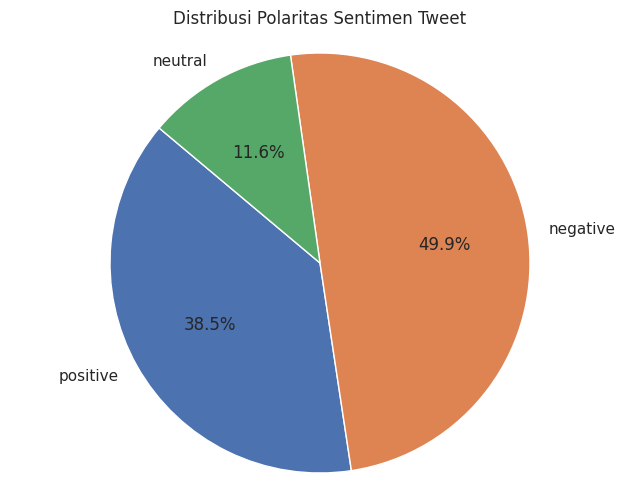

In [22]:
# Data untuk visualisasi berdasarkan output yang diberikan
polarity_counts = {'positive': 539, 'negative': 698, 'neutral': 163}

# Membuat pie chart
plt.figure(figsize=(8, 6))
plt.pie(polarity_counts.values(), labels=polarity_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribusi Polaritas Sentimen Tweet')
plt.show()

In [23]:
pd.set_option("display.max_colwidth", 3000)
negative_tweets = df[df["polarity"] == "negative"]
negative_tweets = (
    negative_tweets[["tweets", "polarity_score", "polarity"]]
    .sort_values(by="polarity_score", ascending=True)[0:10]
    .reset_index(drop=True)
)
negative_tweets.index += 1
negative_tweets[0:5]

,tweets,polarity_score,polarity
1,"Kepala Daerah tidak harus berdrama Korea terus-terusan, tapi harus kerjasama dengan warganya, membuktikan, kalau SURABAYA bisa BERKURANG SEBARAN COVID-19nya. Kami Butuh BUKTI BUKAN TANGISAN dan AMARAH, COVID-19 GAK TAKUT dengan amarahmu apalagi tangisan ala drama Korea...!!!""""",-37,negative
2,"@andyriplay @e100ss Surabaya dan sekitarnya kasusnya turun buanyak buanget, tapi trenggalek, kediri, nganjuk kasusnya masih tinggi lho, gatau kota lain, bahkan sodara di sana banyak yg gatau kalau mereka terindikasi covid karena gamau diperiksa dan minim info, boro boro mau berangkat vaksin.",-28,negative
3,"Pusat perbelanjaan di Surabaya Jawa Timur mulai menerapkan kebijakan baru New Normal, salah satu mal menerapkan sistem satu jalur serta pemeriksaan berlapis. Berita lainnya, 500 orang mengikuti rapid test Covid-19 secara massal di Surabaya. #CariBeritaditvOne #COVID19 https://t.co/8lPFpSsuFy",-27,negative
4,"Cari info vaksin kemana-mana, karena kepikiran ortu punya penyakit bawaan. Angka kematian krn covid tertinggi se-jatim itu Surabaya. Kalau orang tua yg sakit, rasanya sedih banget.",-27,negative
5,#perkasaupdate Tim gugus tugas percepatan penanganan Covid-19 Tulungagung tidak ambil pusing terkait kunjungan mobil PCR bantuan BNPB yang dikritik keras oleh walikota Surabaya. Wakil Juru Bicara Gugus Tugas… https://t.co/8l9ByhSVTD,-26,negative


In [24]:
pd.set_option("display.max_colwidth", 3000)
positive_df = df[df["polarity"] == "positive"]
positive_df = (
    positive_df[["tweets", "polarity_score", "polarity"]]
    .sort_values(by="polarity_score", ascending=False)
    .reset_index(drop=True)
)
positive_df.index += 1
positive_df[0:5]

,tweets,polarity_score,polarity
1,Seorang nenek berusia 100 tahun asal Surabaya sembuh dari Covid-19 setelah jalani perawatan. Khofifah puji kedisiplinan dan kesabaran Kamtin. https://t.co/Y11Z9FHdFp,21,positive
2,"Ayo Rek !! Warga kota Surabaya, terus semangat tingkatkan kepatuhan protokol kesehatan. Sejatinya saat ini, patuh dan displin adalah vaksin Covid-19 !! @BanggaSurabaya @SapawargaSby @OfficialRCTI @liputan6dotcom @BNPB_Indonesia @aw3126 @DivHumas_Polri @PolhukamRI @RTMCJatim",21,positive
3,Seorang nenek berusia 100 tahun asal Surabaya sembuh dari Covid-19 setelah jalani perawatan. Khofifah puji kedisiplinan dan kesabaran Kamtin. https://t.co/R9xshH5vCx,21,positive
4,Seorang nenek berusia 100 tahun asal Surabaya sembuh dari Covid-19 setelah jalani perawatan. Khofifah puji kedisiplinan dan kesabaran Kamtin. https://t.co/BFsz4SViQL,21,positive
5,"@BanggaSurabaya semangat pemkot surabaya terutama bu risma, semoga diberikan kesehatan selalu dan kesabaran buat ngadepin orang-2 yang berusaha mensabotase tanpa permisi😭😭 semoga lelahmu menjadi berkah bu, semoga angka positif covid disurabaya segera berakhir. Aamiiin",18,positive


In [25]:
pd.set_option("display.max_colwidth", 3000)
positive_df = df[df["polarity"] == "neutral"]
positive_df = (
    positive_df[["tweets", "polarity_score", "polarity"]]
    .sort_values(by="polarity_score", ascending=False)
    .reset_index(drop=True)
)
positive_df.index += 1
positive_df[0:5]

,tweets,polarity_score,polarity
1,100-year-old woman recovers from COVID-19 in Surabaya https://t.co/pFpzlwjmFN,0,neutral
2,Polrestabes Surabaya Mulai Vaksin Covid-19 untuk Usia 12-17 Tahun https://t.co/jV1CQVmx6r,0,neutral
3,"Percepatan Vaksinasi Covid-19, Pasmar 2 Ikut Suntik Vaksin Sinovac Masyarakat Pesisir Surabaya https://t.co/uqnpLTaPer via @portalsurya",0,neutral
4,@KAI121 Min apakah di stasiun gubeng surabaya masih melayani vaksin covid?,0,neutral
5,VIDEO - GERAI VAKSIN KELILING . Melayani Warga Surabaya untuk Percepat Vaksinasi Covid-19 #VaksinCovid19 #VaksinasiSurabaya #VaksinasiPatuhi3T5M https://t.co/sBLpeID2Qp,0,neutral


In [26]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words = []
    negative_words = []
    neutral_words = []
    for word in text:
        score_pos = 0
        score_neg = 0
        if word in lexicon_positive:
            score_pos = lexicon_positive[word]
        if word in lexicon_negative:
            score_neg = lexicon_negative[word]

        if score_pos + score_neg > 0:
            positive_words.append(word)
        elif score_pos + score_neg < 0:
            negative_words.append(word)
        else:
            neutral_words.append(word)
    return positive_words, negative_words, neutral_words

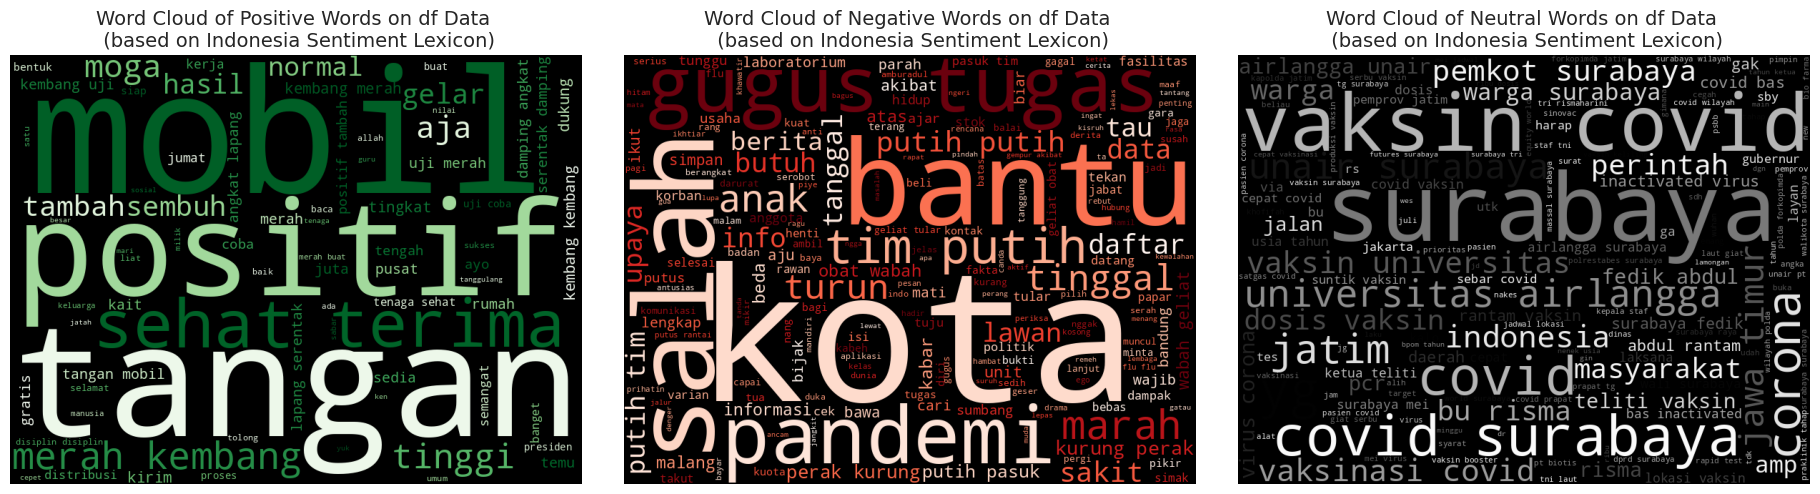

In [27]:
# Visualize positive and negative word cloud

sentiment_words = df["tokenized_tweets"].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]
neutral_words = sentiment_words[2]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
list_words_positive = ""
for row_word in positive_words:
    for word in row_word:
        list_words_positive += " " + (word)
wordcloud_positive = WordCloud(
    width=800, height=600, background_color="black", colormap="Greens", min_font_size=10
).generate(list_words_positive)
ax[0].set_title(
    "Word Cloud of Positive Words on df Data \n (based on Indonesia Sentiment Lexicon)",
    fontsize=14,
)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis("off")

list_words_negative = ""
for row_word in negative_words:
    for word in row_word:
        list_words_negative += " " + (word)
wordcloud_negative = WordCloud(
    width=800, height=600, background_color="black", colormap="Reds", min_font_size=10
).generate(list_words_negative)
ax[1].set_title(
    "Word Cloud of Negative Words on df Data \n (based on Indonesia Sentiment Lexicon)",
    fontsize=14,
)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis("off")

list_words_neutral = ""
for row_word in neutral_words:
    for word in row_word:
        list_words_neutral += " " + (word)
wordcloud_neutral = WordCloud(
    width=800, height=600, background_color="black", colormap="Greys", min_font_size=10
).generate(list_words_neutral)
ax[2].set_title(
    "Word Cloud of Neutral Words on df Data \n (based on Indonesia Sentiment Lexicon)",
    fontsize=14,
)
ax[2].grid(False)
ax[2].imshow((wordcloud_neutral))
fig.tight_layout(pad=0)
ax[2].axis("off")


plt.show()

<h3>Long Short Term Memory (LSTM)</h3>

In [28]:
# Make text preprocessed (tokenized) to untokenized with toSentence Function
def toSentence(list_words):  # Convert list of words into sentence
    sentence = " ".join(word for word in list_words)
    return sentence

X = df['tokenized_tweets'].apply(toSentence)
max_features = 5000

# Tokenize text with specific maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)
X.shape

(1400, 40)

In [29]:
# Encode target data into numerical values
polarity_encode = {'negative' : 0, 'neutral' : 1, 'positive' : 2}
y = df['polarity'].map(polarity_encode).values

# Split the data (with composition data train 80%, data test 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1120, 40) (1120,)
(280, 40) (280,)


In [30]:
# Create model function with default hyperparameter values

def create_model(embed_dim = 16, hidden_unit = 16, dropout_rate = 0.2, optimizers = Adam, learning_rate = 0.001):
    model = Sequential()
    model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X_train.shape[1]))
    model.add(LSTM(units = hidden_unit, activation = 'tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 3, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers(lr = learning_rate), metrics = ['accuracy'])
    print(model.summary())
    return model

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
# Hyperparameter tuning (to know the best hyperparameter for this model)
from keras.wrappers.scikit_learn import KerasClassifier
# Wrapper model with default hyperparameter values
model = KerasClassifier(build_fn = create_model, epochs = 25, batch_size=128)

# Create a dictionary of hyperparameters and their ranges
param_dist = {
    'embed_dim': [32, 64],
    'hidden_unit': [16, 32, 64],
    'dropout_rate': [0.2],
    'optimizers': [Adam, RMSprop],
    'learning_rate': [0.01, 0.001, 0.0001],
    'epochs': [10, 25, 50, 100],
    'batch_size': [128, 256]
}

# Evaluation model with RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=3, n_iter=10)
grid_result = random_search.fit(X_train, y_train)

results = pd.DataFrame()
results['means'] = grid_result.cv_results_['mean_test_score']
results['stds'] = grid_result.cv_results_['std_test_score']
results['params'] = grid_result.cv_results_['params']
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
results.to_csv(r'gridsearchcv_results.csv.csv', index = False, header = True)
results.sort_values(by='means', ascending = False).reset_index(drop=True)

<ipython-input-31-aeecbcab0188>:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = create_model, epochs = 25, batch_size=128)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 32)            160000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Epoch 1/100
6/6 [==============================] - 4s 27ms/step - loss: 1.0289 - accuracy: 0.4812
Epoch 2/100
6/6 [==============================] - 0s 27ms/step - loss: 0.8590 - accuracy: 0.6917
Epoch 3/100
6/6 [==============================] - 0s 24ms/step - loss: 0.4067 - accuracy: 0.9048
Epoch 4/100
6/6 [==============================] - 0s 25ms/step - loss: 0.2405 - accuracy: 0.9437
Epoch 5/100
6/6 [==============================] - 0s 25ms/step - loss: 0.1497 - accuracy: 0.9678
Epoch 6/100
6/6 [==============================] - 0s 25ms/step - loss: 0.0902 - accuracy: 0.9826
Epoch 7/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0655 - accuracy: 0.9826
Epoch 8/100
6/6 [==============================] - 0s 25ms/step - loss: 0.0458 - accuracy: 0.9879
Epoch 9/100
6/6 [==============================] - 0s 28ms/step - loss: 0.0207 - accuracy: 0.9987
Epoch 10/100
6/6 [==============================] - 0s 26ms/step - loss: 0.0151 - accuracy: 0.9973
Epoch 11/100
6

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 2s 37ms/step - loss: 1.0954 - accuracy: 0.4263
Epoch 2/50
3/3 [==============================] - 0s 35ms/step - loss: 1.0825 - accuracy: 0.5282
Epoch 3/50
3/3 [==============================] - 0s 36ms/step - loss: 1.0693 - accuracy: 0.5496
Epoch 4/50
3/3 [==============================] - 0s 36ms/step - loss: 1.0569 - accuracy: 0.5268
Epoch 5/50
3/3 [==============================] - 0s 39ms/step - loss: 1.0374 - accuracy: 0.5241
Epoch 6/50
3/3 [==============================] - 0s 37ms/step - loss: 1.0164 - accuracy: 0.5255
Epoch 7/50
3/3 [==============================] - 0s 35ms/step - loss: 0.9973 - accuracy: 0.5241
Epoch 8/50
3/3 [==============================] - 0s 37ms/step - loss: 0.9826 - accuracy: 0.4933
Epoch 9/50
3/3 [==============================] - 0s 36ms/step - loss: 0.9598 - accuracy: 0.4973
Epoch 10/50
3/3 [==============================] - 0s 39ms/step - loss: 0.9488 - accuracy: 0.5214
Epoch 11/50
3/3 [=======================

2/2 [==============================] - 1s 22ms/step - loss: 1.0998 - accuracy: 0.7078
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 40, 32)            160000    
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
3/3 [==============================] - 3s 39ms/step - loss: 1.0954 - accuracy:

2/2 [==============================] - 1s 17ms/step - loss: 0.8696 - accuracy: 0.7239
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 40, 64)            320000    
                                                                 
 lstm_6 (LSTM)               (None, 16)                5184      
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 51        
                                                                 
Total params: 325,235
Trainable params: 325,235
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
6/6 [==============================] - 3s 50ms/step - loss: 1.0934 - accuracy:

,means,stds,params
0,0.738400,0.026940,"{'optimizers': <class 'keras.optimizers.legacy.adam.Adam'>, 'learning_rate': 0.001, 'hidden_unit': 16, 'epochs': 25, 'embed_dim': 64, 'dropout_rate': 0.2, 'batch_size': 128}"
1,0.733041,0.023344,"{'optimizers': <class 'keras.optimizers.legacy.rmsprop.RMSprop'>, 'learning_rate': 0.001, 'hidden_unit': 16, 'epochs': 50, 'embed_dim': 64, 'dropout_rate': 0.2, 'batch_size': 128}"
2,0.719636,0.008502,"{'optimizers': <class 'keras.optimizers.legacy.adam.Adam'>, 'learning_rate': 0.001, 'hidden_unit': 16, 'epochs': 50, 'embed_dim': 32, 'dropout_rate': 0.2, 'batch_size': 256}"
3,0.718781,0.024270,"{'optimizers': <class 'keras.optimizers.legacy.rmsprop.RMSprop'>, 'learning_rate': 0.001, 'hidden_unit': 32, 'epochs': 50, 'embed_dim': 32, 'dropout_rate': 0.2, 'batch_size': 128}"
4,0.716095,0.019693,"{'optimizers': <class 'keras.optimizers.legacy.adam.Adam'>, 'learning_rate': 0.01, 'hidden_unit': 32, 'epochs': 25, 'embed_dim': 64, 'dropout_rate': 0.2, 'batch_size': 256}"
5,0.713409,0.017634,"{'optimizers': <class 'keras.optimizers.legacy.rmsprop.RMSprop'>, 'learning_rate': 0.01, 'hidden_unit': 16, 'epochs': 100, 'embed_dim': 32, 'dropout_rate': 0.2, 'batch_size': 128}"
6,0.703584,0.016339,"{'optimizers': <class 'keras.optimizers.legacy.adam.Adam'>, 'learning_rate': 0.001, 'hidden_unit': 32, 'epochs': 100, 'embed_dim': 64, 'dropout_rate': 0.2, 'batch_size': 256}"
7,0.583913,0.018946,"{'optimizers': <class 'keras.optimizers.legacy.rmsprop.RMSprop'>, 'learning_rate': 0.001, 'hidden_unit': 64, 'epochs': 10, 'embed_dim': 32, 'dropout_rate': 0.2, 'batch_size': 128}"
8,0.566933,0.024614,"{'optimizers': <class 'keras.optimizers.legacy.adam.Adam'>, 'learning_rate': 0.0001, 'hidden_unit': 32, 'epochs': 100, 'embed_dim': 32, 'dropout_rate': 0.2, 'batch_size': 256}"
9,0.500884,0.031421,"{'optimizers': <class 'keras.optimizers.legacy.adam.Adam'>, 'learning_rate': 0.0001, 'hidden_unit': 16, 'epochs': 25, 'embed_dim': 32, 'dropout_rate': 0.2, 'batch_size': 128}"


In [32]:
# From results above, we know the best hyperparameter for this model is :
# {'batch_size': 128, 'dropout_rate': 0.2, 'embed_dim': 32, 'epochs': 10, 'hidden_unit': 16, 'learning_rate': 0.001, 'optimizers': <class 'keras.optimizers.RMSprop'>}

# Create the model with the best hyperparameter which has been determined
model = KerasClassifier(build_fn = create_model,
                        # Model Parameters
                        dropout_rate = 0.2,
                        embed_dim = 64,
                        hidden_unit = 32,
                        optimizers = RMSprop,
                        learning_rate = 0.01,

                        # Fit Parameters
                        epochs=25,
                        batch_size=128,
                        # Initiate validation data, which is 10% data from data train. It's used for evaluation model
                        validation_split = 0.1)


model_prediction = model.fit(X_train, y_train)

<ipython-input-32-ca1ae1dba46e>:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = create_model,


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 40, 64)            320000    
                                                                 
 lstm_31 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 3)                 99        
                                                                 
Total params: 332,515
Trainable params: 332,515
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 123ms/step - loss: 0.9627 - accuracy: 0.5119 - val_loss: 0.8290 - val_accuracy: 0.6339
Epoch 2/25
8/8 [==============================] - 1s 71ms/step - loss: 0.5298 - accuracy: 0.8075 - val_loss: 0.9008 - val_accuracy: 0.6696
Epoch 3/25
8/8 [==============================] - 1s 72ms/step - loss: 0.2589 - accuracy: 0.9137 - val_loss: 0.9307 - val_accuracy: 0.6696
Epoch 4/25
8/8 [==============================] - 1s 73ms/step - loss: 0.1203 - accuracy: 0.9673 - val_loss: 1.0840 - val_accuracy: 0.6875
Epoch 5/25
8/8 [==============================] - 1s 68ms/step - loss: 0.0724 - accuracy: 0.9841 - val_loss: 1.1364 - val_accuracy: 0.6696
Epoch 6/25
8/8 [==============================] - 1s 68ms/step - loss: 0.0483 - accuracy: 0.9851 - val_loss: 1.2493 - val_accuracy: 0.7054
Epoch 7/25
8/8 [==============================] - 1s 68ms/step - loss: 0.0374 - accuracy: 0.9891 - val_loss: 2.4917 - val_accuracy: 0.4375
Epoch 8/25
8/8 [=====================

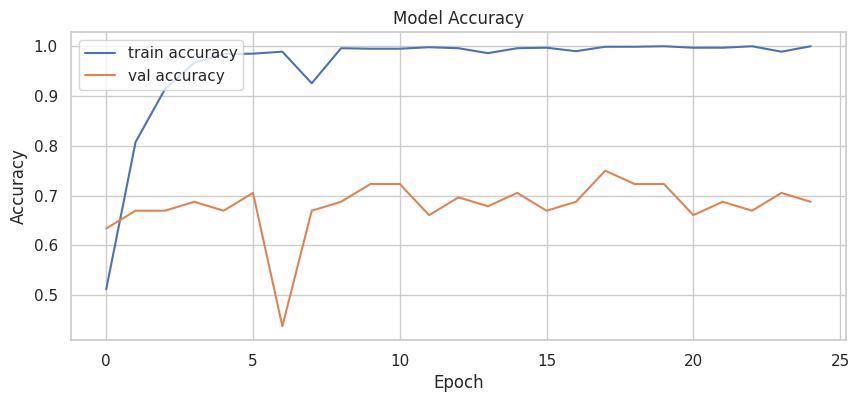

In [33]:
# Visualization model accuracy (train and val accuracy)

fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(model_prediction.history['accuracy'], label = 'train accuracy')
ax.plot(model_prediction.history['val_accuracy'], label = 'val accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'upper left')
plt.show()

9/9 [==============================] - 1s 8ms/step
Model Accuracy on Test Data: 0.7285714285714285


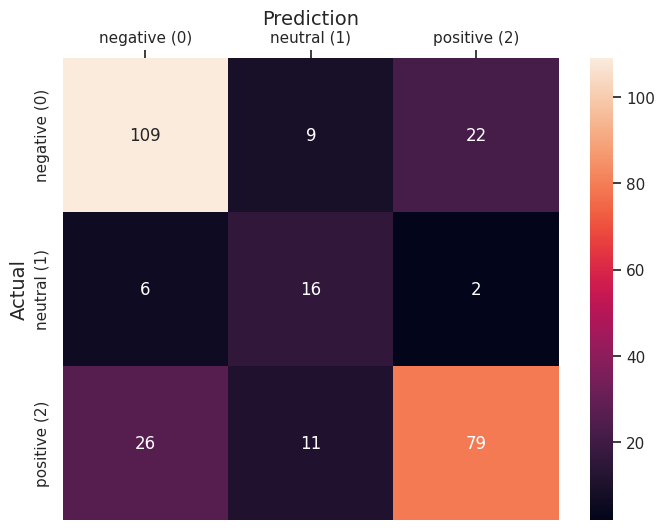

In [34]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'g', annot = True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()

In [35]:
# Results from prediction sentiment on data test
text_clean = df['preprocessed_tweets']
text_train, text_test = train_test_split(text_clean, test_size = 0.2, random_state = 0)
result_test = pd.DataFrame(data = zip(text_test, y_pred), columns = ['text', 'polarity'])
polarity_decode = {0 : 'Negative', 1 : 'Neutral', 2 : 'Positive'}
result_test['polarity'] = result_test['polarity'].map(polarity_decode)
pd.set_option('max_colwidth', 300)
result_test

,text,polarity
0,polrestabes surabaya vaksin covid usia tahun,Neutral
1,prioritas risma khofifah mobil pcr corona surabaya jatim,Negative
2,vaksin turun imun simak informasi mitos fakta vaksin covid,Negative
3,pasien positif corona jatim tambah surabaya,Positive
4,inovasi pandemi covid polrestabes surabaya luncur mobil vaksin presisi keliling,Neutral
...,...,...
275,habis stok pemkot surabaya aju tambah juta vaksin covid kemenkes,Negative
276,pandemi corona bin gelar rapid test massal surabaya,Negative
277,wali kota surabaya tri rismaharini sesal mobil laboratorium bnpb sedia bantu kota surabaya alih daerah gugus tugas covid jatim,Negative
278,kalo surabaya jd epicentrum sebar covid jatimlha mobil pcr kirim nang daerah liyane opo ngenteni sak grahadi positif kabeh ta,Positive


Predict with Other Data

In [39]:
# Initializing and preprocessing new text data
otherData = pd.DataFrame()
otherData['text'] = ['Tinjau vaksinasi massal di Surabaya, Puan Maharani berikan 30 ribu dosis vaksin covid 19 untuk warga Jatim.',
                     'Inovasi Baru Di Masa Pandemi Covid-19, Polrestabes Surabaya Luncurkan Mobil Vaksin Presisi Keliling',
                     'Ada kabar baik dari @gojekindonesia & Halodoc, yang baru aja menghadirkan Pos Pelayanan Vaksinasi COVID-19 Drive-thru pertama di Jawa Timur, di Universitas Surabaya.',
                     'Jumlah Pasien Covid-19 di Asrama Haji Surabaya Meningkat Dua Kali Lipat',
                     'Malang sama Surabaya jangan dulu menerapkan New Normal. Masi Tinggi angka covid nya.'
                    ]

otherData['text'] = otherData['text'].apply(preprocess_text)
otherData['text_tokenized'] = otherData['text'].apply(tokenize_tweet)
otherData

,text,text_tokenized
0,tinjau vaksinasi massal surabaya puan maharani ribu dosis vaksin covid warga jatim,"[tinjau, vaksinasi, massal, surabaya, puan, maharani, ribu, dosis, vaksin, covid, warga, jatim]"
1,inovasi pandemi covid polrestabes surabaya luncur mobil vaksin presisi keliling,"[inovasi, pandemi, covid, polrestabes, surabaya, luncur, mobil, vaksin, presisi, keliling]"
2,kabar halodoc aja hadir pos layan vaksinasi covid drivethru jawa timur universitas surabaya,"[kabar, halodoc, aja, hadir, pos, layan, vaksinasi, covid, drivethru, jawa, timur, universitas, surabaya]"
3,pasien covid asrama haji surabaya tingkat lipat,"[pasien, covid, asrama, haji, surabaya, tingkat, lipat]"
4,malang surabaya terap new normal mas tinggi angka covid,"[malang, surabaya, terap, new, normal, mas, tinggi, angka, covid]"


In [40]:
# Preprocessing text data

X_otherData = otherData['text_tokenized'].apply(toSentence)
X_otherData = tokenizer.texts_to_sequences(X_otherData.values)
X_otherData = pad_sequences(X_otherData, maxlen = X.shape[1])
X_otherData

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  170,    8,   66,    1,  222,
         473,   53,   19,    3,    2,   14,    6],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  428,   52,    2,
         102,    1,  280,   11,    3,  336,  112],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  183,  884,   74,  723,  589,   77,
           8,    2, 1588,   22,   24,   18,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  

In [41]:
# Results from prediction sentiment on text data

y_pred_otherData = model.predict(X_otherData)
otherData['Result Prediction'] = y_pred_otherData

polarity_decode = {0 : 'Negative', 1 : 'Neutral', 2 : 'Positive'}
otherData['Result Prediction'] = otherData['Result Prediction'].map(polarity_decode)
otherData

1/1 [==============================] - 0s 147ms/step


,text,text_tokenized,Result Prediction
0,tinjau vaksinasi massal surabaya puan maharani ribu dosis vaksin covid warga jatim,"[tinjau, vaksinasi, massal, surabaya, puan, maharani, ribu, dosis, vaksin, covid, warga, jatim]",Neutral
1,inovasi pandemi covid polrestabes surabaya luncur mobil vaksin presisi keliling,"[inovasi, pandemi, covid, polrestabes, surabaya, luncur, mobil, vaksin, presisi, keliling]",Neutral
2,kabar halodoc aja hadir pos layan vaksinasi covid drivethru jawa timur universitas surabaya,"[kabar, halodoc, aja, hadir, pos, layan, vaksinasi, covid, drivethru, jawa, timur, universitas, surabaya]",Positive
3,pasien covid asrama haji surabaya tingkat lipat,"[pasien, covid, asrama, haji, surabaya, tingkat, lipat]",Positive
4,malang surabaya terap new normal mas tinggi angka covid,"[malang, surabaya, terap, new, normal, mas, tinggi, angka, covid]",Negative
